Lungs Cancer ? 

Problem Satement 

About Data Sets 

Aims and Objective 

In [ ]:
# Essential Library

In [13]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import cv2
import warnings
warnings.filterwarnings('ignore')



In [14]:
#for dirname, _, filenames in os.walk('./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/'):
#    for filename in filenames:
#        dir_list = os.path.join(dirname, filename)

In [15]:
#dir_list = './NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/'

bengin_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Bengin cases'
malignant_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Malignant cases'
normal_path = r'./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Normal cases'

img_classes = ["Bengin cases", "Malignant cases", "Normal cases"] # Categories 
path_list = [bengin_path, malignant_path, normal_path]

In [16]:
img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

,img_path,label
0,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
1,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
2,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
3,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases
4,./NIDCH-Dhaka-Lungs-Cancer-Datasets/Dataset/Be...,Bengin cases


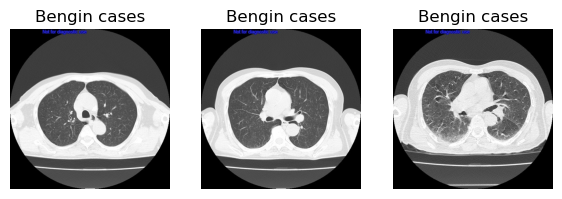

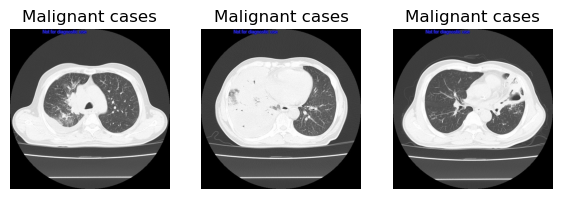

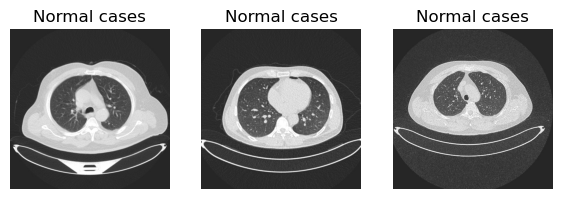

In [17]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (7,7))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

# Exploratory Data Analysis 

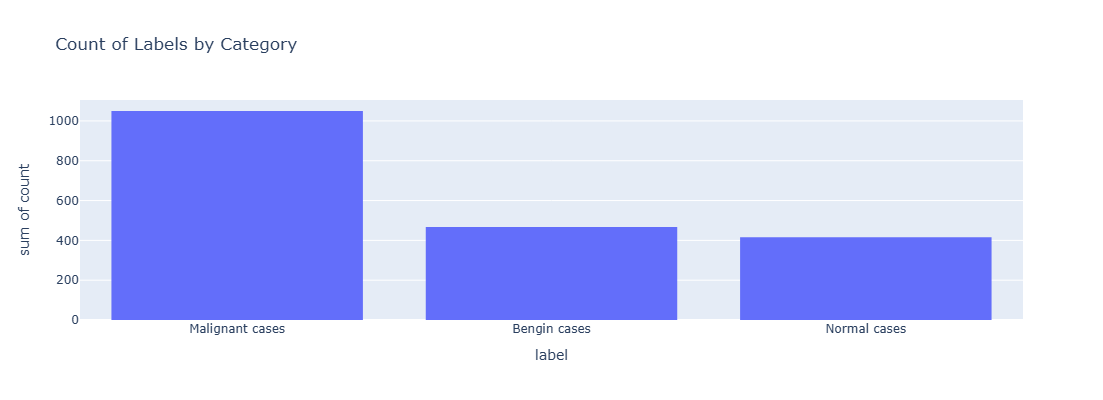

In [19]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "label", y = "count", width=800,
    height=400,
    title="Count of Labels by Category")
fig.show()